**Import Modules**

In [ ]:
!pip install nltk

In [ ]:
!pip install pydot

In [ ]:
!pip install graphviz

In [1]:
import os
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#from google.colab import drive
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.layers import Input , Dense , LSTM, Bidirectional, GRU , Embedding , Dropout , add, MultiHeadAttention, Attention, BatchNormalization, Concatenate, RepeatVector

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Mount the Google Drive**

In [ ]:
#drive.mount('/content/drive')

In [ ]:
#**Set Directories**

In [2]:
BASE_DIR = "/kaggle/input/flickr30k"
WORKING_DIR = '/kaggle/working'

**Load VGG16 Model**

In [ ]:
# VGG feature extraction
#_model = VGG16()
#_model = Model(inputs = _model.inputs , outputs = _model.layers[-2].output)
#_model.trainable=False
#_model.summary()

In [3]:
# ResNet feature extraction
_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
_model.trainable=False
#_model.summary()

94765736/94765736 [==============================] - 3s 0us/step


In [4]:
features = {}
directory = "/kaggle/input/flickr30k/flickr30k_images"

In [ ]:
print(len(os.listdir(directory)))

**Extract the image features Using VGG16**

In [9]:


for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = _model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature
    


100%|██████████| 8091/8091 [09:58<00:00, 13.53it/s]


In [5]:
def get_features(path_of_image):
    global _model
    image = load_img(path_of_image, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = _model.predict(image, verbose=0)
    return feature

**Store Features in Pickle**

In [11]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features-res-8k.pkl'), 'wb'))

**Load Features from Pickle**

In [6]:
with open("/kaggle/input/res-30-features/features-res-30k.pkl", 'rb') as f:
    features = pickle.load(f)

In [190]:
features1, features2,features3={},{},{}
count=0
for key, _feature in features.items():
    if count<=8090:
        features1[key] = _feature
    elif count>8090 and count<=16181:
        features2[key] = _feature
    elif count>1681 and count<=24272:
        features3[key] = _feature
    count+=1
print(len(features1),len(features2),len(features3))

8091 8091 8091


**Load the Captions Data**

In [7]:
with open("/kaggle/input/flickr30k/captions.txt", 'r') as f:
    next(f)
    captions_doc = f.read()

**Split and Append the Captions Data with the Image**

In [8]:
mapping = {}
mapping1,mapping2, mapping3= {},{},{}
count=0
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[2:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)
   
    
print(len(mapping1), len(mapping2), len(mapping3), len(mapping))
        
  
                
       

100%|██████████| 158916/158916 [00:00<00:00, 421452.59it/s]

0 0 0 31783


In [211]:
count=0
for key, _caption in mapping.items():
    if count<=8090:
        mapping1[key] = _caption[count]
    elif count>8090 and count<=16181:
        features2[key] = _feature
    elif count>1681 and count<=24272:
        features3[key] = _feature
    
print(len(mapping1), len(mapping2), len(mapping3), len(mapping))


1619 1618 1618 31783


**No. of Images loaded**

In [9]:
len(features)

31783

**Preprocess Text Data**

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

**Before Preprocess of Text**

In [11]:
mapping['1000919630']

['A man sits in a chair while holding a large stuffed animal of a lion .',
 'A man is sitting on a chair holding a large stuffed animal .',
 'A man completes the finishing touches on a stuffed lion .',
 'A man holds a large stuffed lion toy .',
 'A man is smiling at a stuffed lion']

**Preprocess the text**

In [12]:
clean(mapping)

**After Preprocess of text**

In [13]:
mapping['1000919630']

['startseq man sits in chair while holding large stuffed animal of lion endseq',
 'startseq man is sitting on chair holding large stuffed animal endseq',
 'startseq man completes the finishing touches on stuffed lion endseq',
 'startseq man holds large stuffed lion toy endseq',
 'startseq man is smiling at stuffed lion endseq']

In [ ]:
features_8k={}
for 

In [14]:
features['1000344755'].shape

(1, 2048)

**Store the Preprocessed Captions into List**

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

158915

**Let us see the first ten captions**

In [17]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

**Processing of Text Data**

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

18319

**No. of unique words**

In [20]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

74

**Train Test Split**

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]
#val = int(len(image_ids)*0.5)
#va = image_ids[]

**Now we will define a batch and include the padding sequence**

In [23]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
#Previous Attention Layer
import tensorflow as tf
def AttentionLayer(inputs, time_steps):
    attention = tf.keras.layers.Attention(use_scale=True)([inputs, inputs])
    attended_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs, attention])
    return attended_inputs


In [ ]:
def _AttentionLayer(inputs, time_steps):
    attention = tf.keras.layers.Attention()([inputs[0], inputs[1]])
    attended_inputs = tf.keras.layers.Concatenate(axis=-1)([inputs[0], attention])
    return attended_inputs

In [24]:
model_dir="/kaggle/working"
model_file="LSTM_model5.h5"
model_file_bilstm="30k-BiLSTM-model-55.h5"

**Model Creation**

Model doesn't exist, so the new model is built


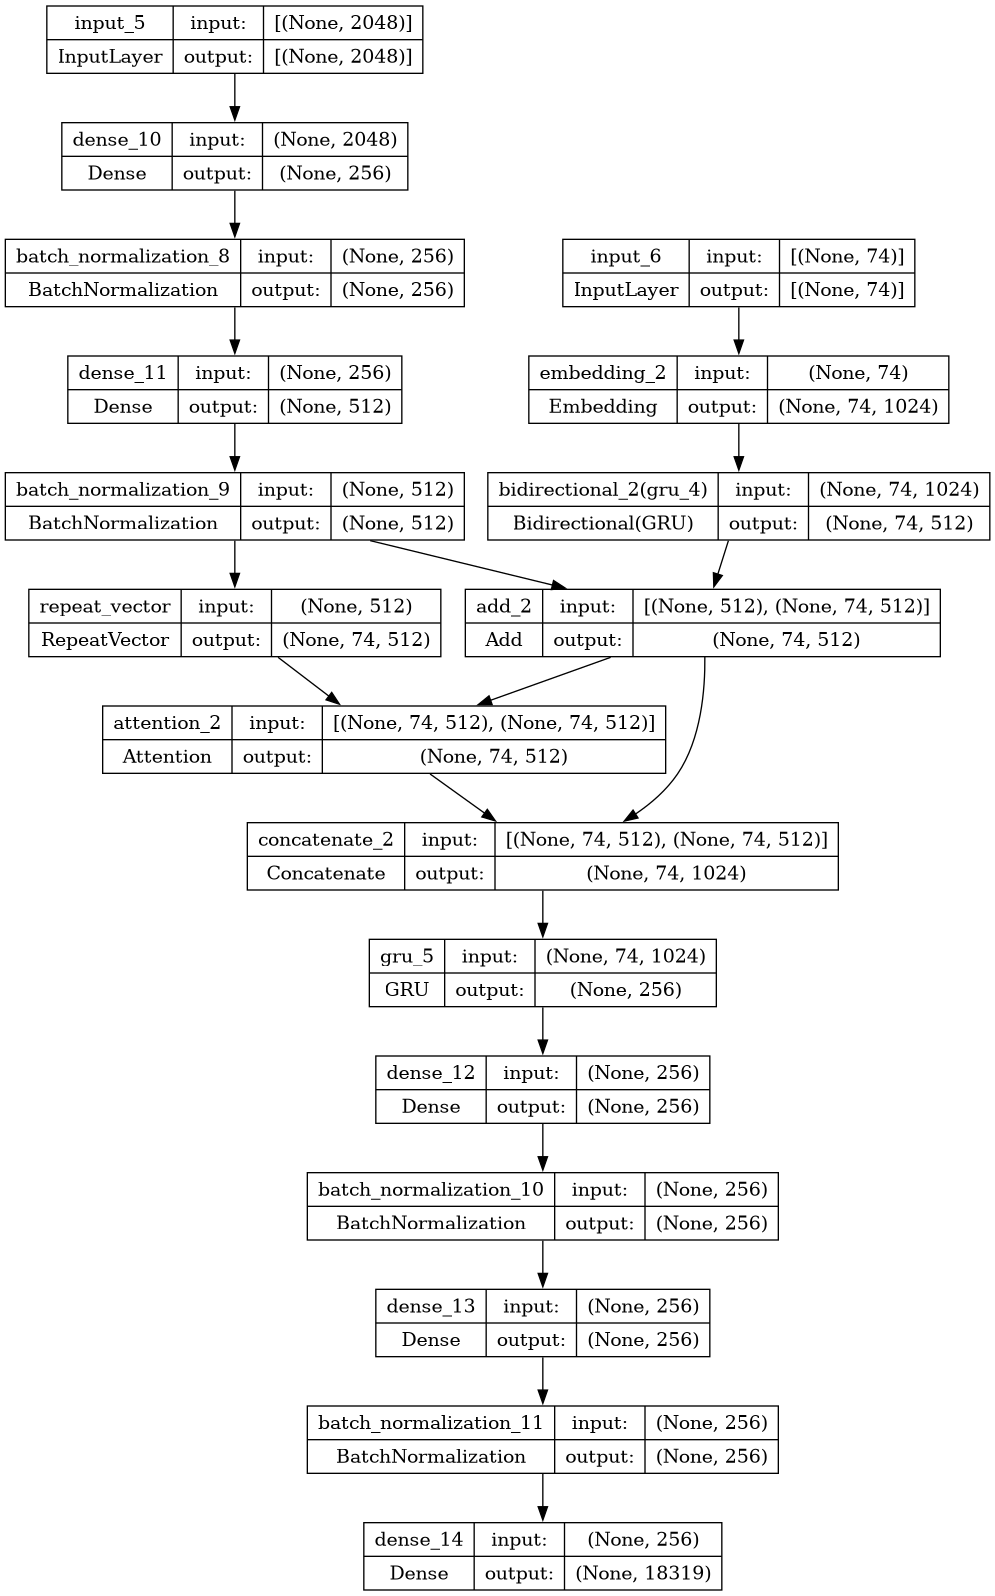

In [33]:

#from tensorflow_addons.layers import Transformer
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

_optimizer=Adam(lr=0.001) #try starting with low learning rate like 0.0001 something 
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=2, min_lr=0.000000000000000000000000000000001) #try decreasing the patience to '2'

def build_model(model_file_name="LSTM_model200.h5"):
    
    global model_dir
    global model_file
    global inputs1
    global inputs2
    global outputs
    global _optimizer
    if os.path.exists(model_dir):
        if model_file_name in os.listdir(model_dir):
            print(f"Returning the required model: {model_file_name}\n")
            model=tf.keras.models.load_model(os.path.join(model_dir, model_file_name))
            return model
        else:
            print("Model doesn't exist, so the new model is built")
            model = Model(inputs=[inputs1, inputs2], outputs=outputs)
            model.compile(loss='categorical_crossentropy', optimizer=_optimizer, metrics=['accuracy'])
            return model
    
    else:
        print("Model doesn't eixst, so the new model is built.\n")
        os.mkdir(model_dir)
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        model.compile(loss='categorical_crossentropy', optimizer=_optimizer, metrics=['accuracy'])
        return model



#If OOM error persists, try reducing the model complexity, reduce the layers, reduce the units in layers etc
inputs1 = Input(shape=(2048,)) 
fe1 = Dense(256, activation='relu', kernel_initializer=GlorotNormal(seed=41))(inputs1) #can try not setting the seed
_fe1 = BatchNormalization()(fe1)
fe2 = Dense(512, activation='relu', kernel_initializer=GlorotNormal(seed=42))(_fe1)
_fe2 = BatchNormalization()(fe2)
#fe3 = Dense(256, activation='relu', kernel_initializer=GlorotUniform(seed=43))(_fe2)
#_fe3 = BatchNormalization()(fe3)
#fe4 = Dense(256, activation='relu', kernel_initializer=glorot_uniform(seed=45))(_fe3)

#fe2_repeat = RepeatVector(max_length)(_fe2) 



inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 1024, mask_zero=True)(inputs2)
se2 = Bidirectional(GRU(256, return_sequences=True, kernel_initializer=GlorotNormal( )))(se1)

#decoder1=add([_fe2, se2])
attention = Attention()([_fe2, se2]) #replace decoder1 with se2
context_combined = Concatenate(axis=-1)([se2, attention]) #replace decoder1 with se2

#decoder1=context_combined
decoder1 = GRU(256, kernel_initializer=GlorotNormal(seed=46))(context_combined) #try the model without this 2nd GRU or try making it unidirectional and also increase the no of units in unidirectional

#decoder1 = add([fe3, se2])



decoder4 = Dense(256, activation='relu', kernel_initializer=GlorotNormal(seed=44))(decoder1)
_decoder4 = BatchNormalization()(decoder4)
decoder5 = Dense(256, activation='relu', kernel_initializer=GlorotNormal(seed=45))(_decoder4)
_decoder5 = BatchNormalization()(decoder5)
outputs = Dense(vocab_size, activation='softmax', kernel_initializer=GlorotNormal(seed=46))(_decoder5) 


model=build_model(model_file_bilstm)
plot_model(model, show_shapes=True)
    


In [34]:
_epochs=0
_epochs
#model=tf.keras.models.load_model("30k-BiLSTM-Attn-model-"+str(_epochs)+".h5")

0

**Train Model**

In [56]:
# call the model generation first then call this block

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#model=tf.keras.models.load_model("30k-BiLSTM-Attn-model-"+str(_epochs)+".h5")


no_of_epochs=20
_epochs += no_of_epochs
batch_size = 32
steps = len(train) // batch_size

checkpoint = ModelCheckpoint("30k-BiLSTM-Attn-model-"+str(_epochs)+".h5", save_best_only=True)
early_stopping = EarlyStopping(patience=4, restore_best_weights=True)

generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
model.fit(generator, epochs=no_of_epochs, steps_per_epoch=steps, verbose=1, callbacks=[reduce_lr, checkpoint, early_stopping])

filename="30k-BiLSTM-Attn-model-"+str(_epochs)+".h5"
model.save(os.path.join(model_dir,filename))



Epoch 1/20
893/893 [==============================] - 757s 847ms/step - loss: 3.0904 - accuracy: 0.3497 - lr: 0.0010
Epoch 2/20
893/893 [==============================] - 760s 850ms/step - loss: 2.9666 - accuracy: 0.3638 - lr: 0.0010
Epoch 3/20
893/893 [==============================] - 759s 850ms/step - loss: 2.8647 - accuracy: 0.3763 - lr: 0.0010
Epoch 4/20
893/893 [==============================] - 761s 852ms/step - loss: 2.7769 - accuracy: 0.3875 - lr: 0.0010
Epoch 5/20
893/893 [==============================] - 763s 854ms/step - loss: 2.7016 - accuracy: 0.3984 - lr: 0.0010
Epoch 6/20
893/893 [==============================] - 757s 847ms/step - loss: 2.6348 - accuracy: 0.4076 - lr: 0.0010
Epoch 7/20
893/893 [==============================] - 756s 847ms/step - loss: 2.5707 - accuracy: 0.4169 - lr: 0.0010
Epoch 8/20
893/893 [==============================] - 755s 845ms/step - loss: 2.5066 - accuracy: 0.4262 - lr: 0.0010
Epoch 9/20
893/893 [==============================] - 755s 846ms

In [26]:
#call this to clear the session graph, might help in clearing resources

tf.keras.backend.clear_session()

In [54]:
#uncomment to use this and don't call this unnecessarily, it changes the learning rate

#print(model.optimizer.learning_rate.numpy())
#model.optimizer.learning_rate.assign(0.0001)
#reduce_lr.on_epoch_begin(logs={"lr": new_learning_rate})
#print(model.optimizer.learning_rate.numpy())

0.001
1e-04


In [ ]:
#don't call this unnecessarily, changes the learning rate

#learning_rate=_optimizer.learning_rate.numpy()
#print("Previous Learning Rate: ", learning_rate)
#new_learning_rate=round(learning_rate+0.001, 3)

#model.optimizer.learning_rate.assign(new_learning_rate)
#reduce_lr.on_epoch_begin(epoch=None, logs={"lr": new_learning_rate})

#print("New learning rate:", new_learning_rate,"\n")

**Generate Captions for the Image**

In [57]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

**Convert the predicted index from the model into a word**

In [58]:
def predict_caption(model, image, tokenizer, max_length):
    #global model
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

**Model Validation**

In [27]:
actual, predicted = list(), list()
validation_batch_size = 32
for i in range(0, len(test), validation_batch_size):
    batch_keys = test[i:i + validation_batch_size]
    for key in tqdm(batch_keys):
        captions = mapping[key]
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        actual.append(actual_captions)
        predicted.append(y_pred)
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

meteor_scores = [meteor_score(actual[i], predicted[i]) for i in range(len(actual))]
average_meteor = sum(meteor_scores) / len(meteor_scores)
print(f"\nAverage METEOR Score: {average_meteor}\n")

100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


BLEU-1: 0.520123
BLEU-2: 0.274091


**Visualize the Results**

In [59]:
def generate_caption(image_name):
    #global model
    image_id=image_name.split('/')[-1].split('.')[0]
    image = Image.open(image_name)
    image_features=get_features(image_name)
    
    
    y_pred = predict_caption(model, image_features, tokenizer, max_length)
    print(image_features.ndim, image_features.shape)
    print('\n-------------------Caption------------------\n')
    print(y_pred,"\n")
    plt.imshow(image)
    
        
    #print(features[image_id].shape)
   # print(image_features[1,:60] == features[image_id][1,:60])

2 (1, 2048)

-------------------Caption------------------

startseq man in midair leaps into the air endseq 



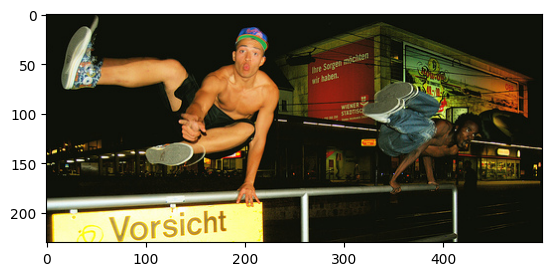

In [60]:
generate_caption("/kaggle/input/flickr30k/flickr30k_images/1001545525.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq two young boys are playing in the yard endseq 



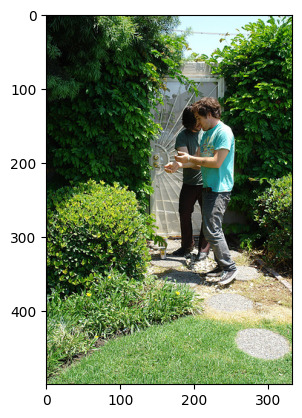

In [61]:
generate_caption("/kaggle/input/flickr30k/flickr30k_images/1000092795.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq six women are sitting around living room endseq 



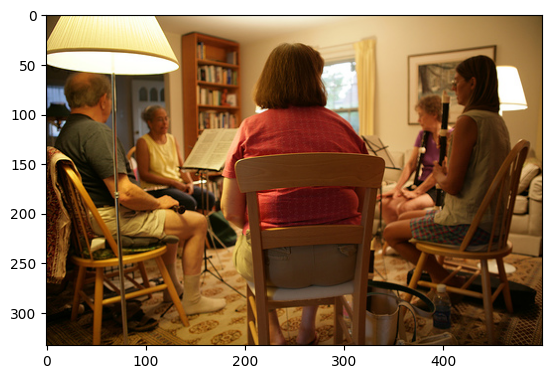

In [62]:
generate_caption("/kaggle/input/flickr30k/flickr30k_images/1003420127.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq two men are sitting on bench in front of the side of building with model airplane in the background endseq 



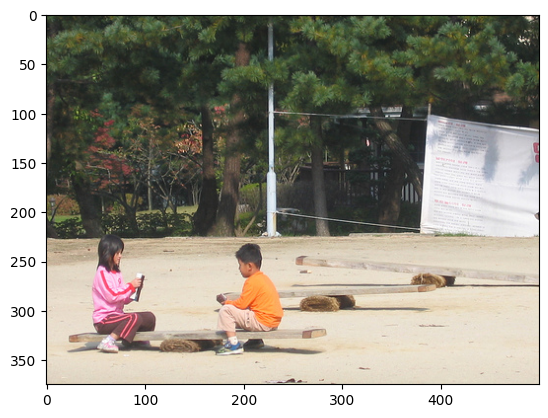

In [63]:
generate_caption("/kaggle/input/flickr30k/flickr30k_images/1006452823.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq three men are playing badminton endseq 



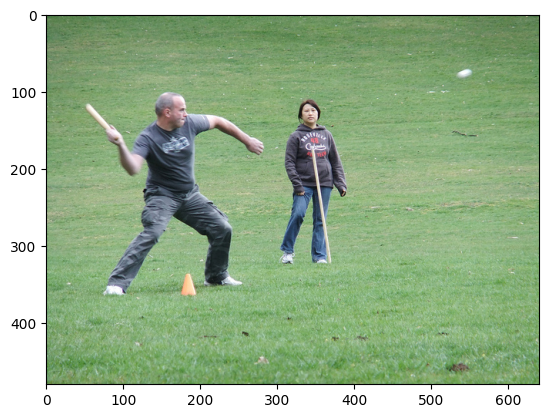

In [64]:
generate_caption("/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000063.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq baseball player is swinging bat at the bat endseq 



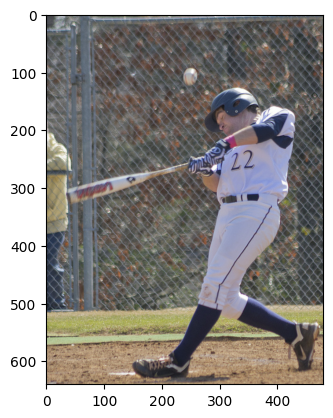

In [65]:
generate_caption("/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000016.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq construction worker is sanding it off of roof endseq 



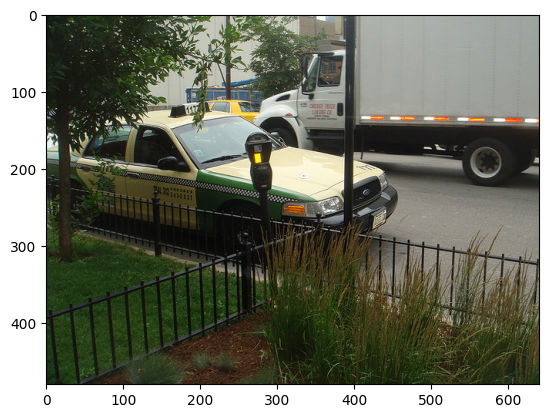

In [66]:
generate_caption("/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000001.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq police officer in madrid spain looks like he is holding his helmet endseq 



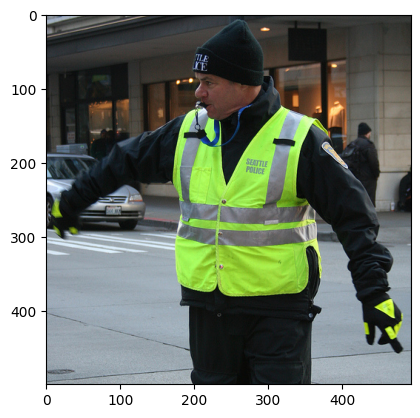

In [67]:
generate_caption("/kaggle/input/flickr8k/Images/405615014_03be7ef618.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq baseball player is about to throw baseball endseq 



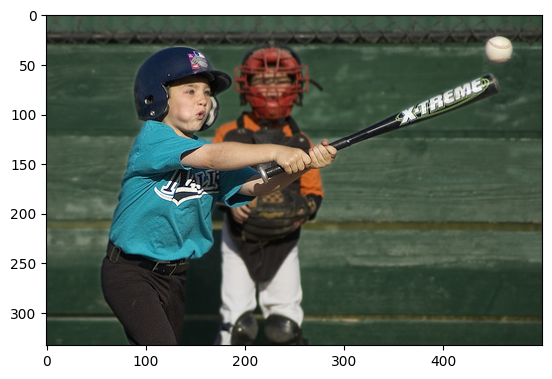

In [68]:
generate_caption("/kaggle/input/flickr8k/Images/141139674_246c0f90a1.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq the black dog is leaping after the ball endseq 



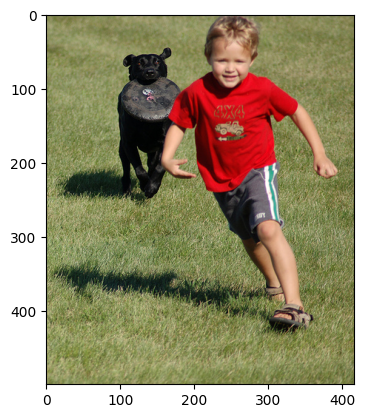

In [69]:
generate_caption("/kaggle/input/flickr8k/Images/221973402_ecb1cd51f1.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq man in yellow shirt is riding bicycle while other people are riding on track endseq 



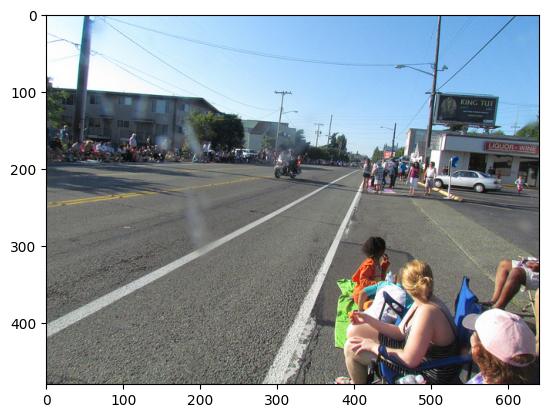

In [70]:
generate_caption("/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000318.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq basketball player in black is in the air with his left hand and his right leg in the air endseq 



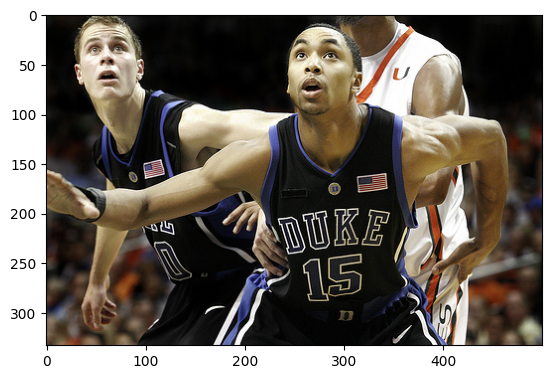

In [71]:
generate_caption("/kaggle/input/flickr8k/Images/2285152690_3fb93f65f1.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq four people in native dress dancing endseq 



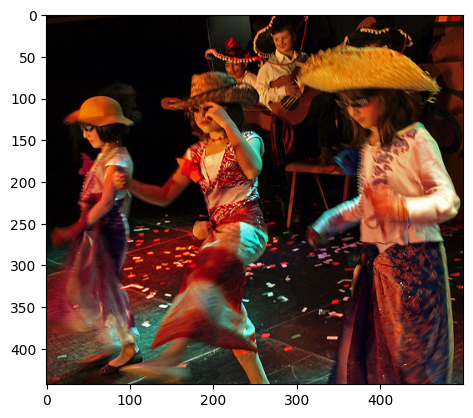

In [72]:
generate_caption("/kaggle/input/flickr8k/Images/2346523971_d3f1e12ce4.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq group of boys playing soccer endseq 



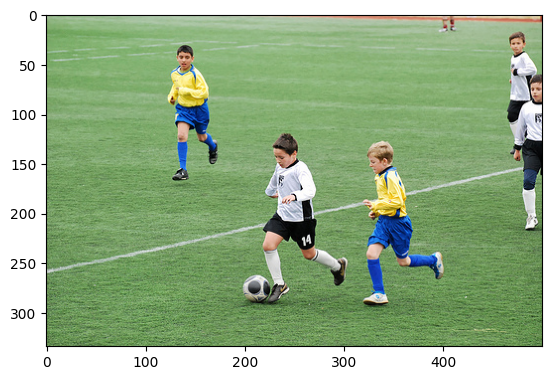

In [73]:
generate_caption("/kaggle/input/flickr8k/Images/2354792215_eef2bdc753.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq man is sitting on top of chain shaking water endseq 



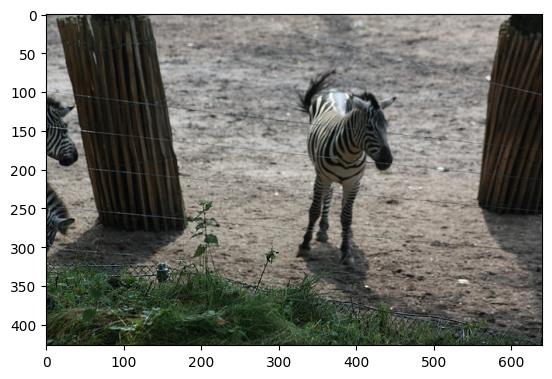

In [74]:
generate_caption("/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000080.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq skier doing trick on snowboard endseq 



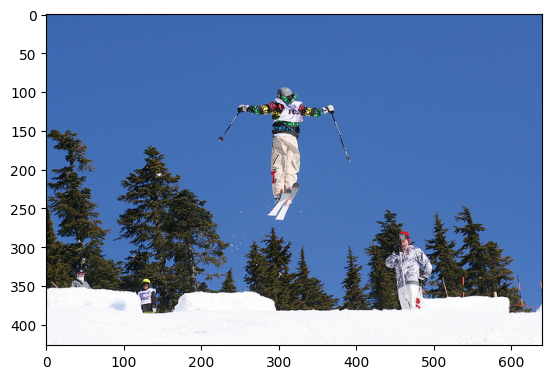

In [75]:
generate_caption("/kaggle/input/coco-2017-dataset/coco2017/val2017/000000002473.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq man is standing on traffic bridge that is low over it endseq 



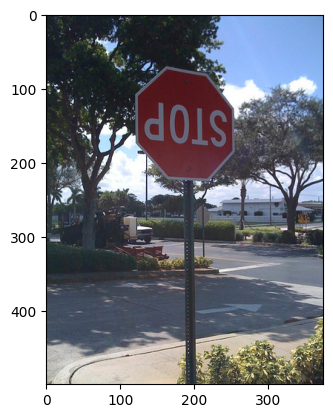

In [76]:
generate_caption("/kaggle/input/coco-2017-dataset/coco2017/val2017/000000000724.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq young boy is going headfirst down blue slide endseq 



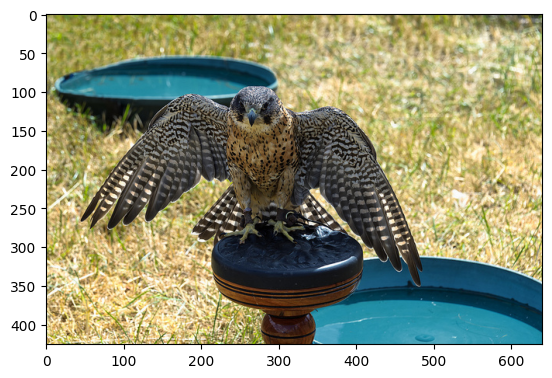

In [77]:
generate_caption("/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000106.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq two children are playing in the hay with trees everywhere endseq 



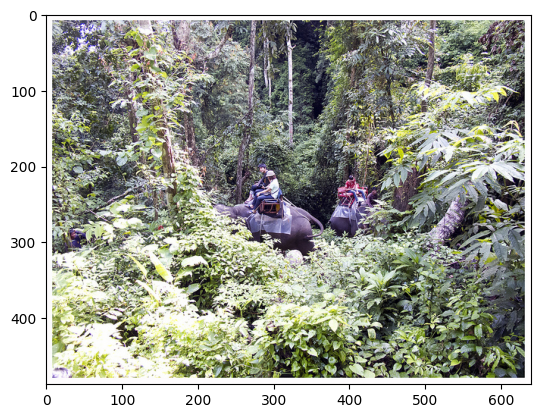

In [78]:
generate_caption("/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000061.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq man in blue shirt and jeans is using microscope endseq 



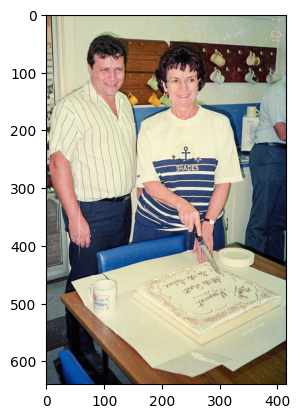

In [79]:
generate_caption("/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000113.jpg")

2 (1, 2048)

-------------------Caption------------------

startseq cat sits in wooden shop endseq 



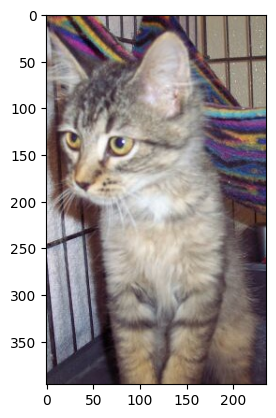

In [80]:
generate_caption("/kaggle/input/natural-images/natural_images/cat/cat_0000.jpg")

In [ ]:
print(features["109202801_c6381eef15"].ndim)

2 (1, 2048)

-------------------Caption------------------

startseq man in suit is singing into microphone endseq 



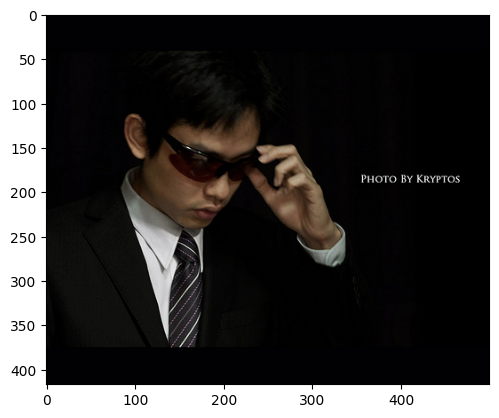

In [81]:
generate_caption("/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000171.jpg")

In [282]:
model=build_model("8k-BiLSTM-model-100.h5")

Returning the required model: 8k-BiLSTM-model-100.h5

